# Web Scrapper

This notebooks explains the use of the scraping functions described below.

In [ ]:
!pip install -r requirements.txt -U

In [1]:
# Imports
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import pickle
import spacy
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from bokeh.plotting import figure, show, output_notebook
from bokeh.palettes import Category10 as Palette
# Spacy pretrained model
nlp = spacy.load('en_core_web_md')

In [2]:
import requests
import json
import pandas as pd
import numpy as np
import pyreadr
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm_notebook as tqdm_nb
from bs4 import BeautifulSoup
import langdetect
import glob
import os
# Set tqdm to pandas dataframes
tqdm_notebook.pandas()

### Custom Google Search
To create a `.csv` file with the result of the custom query execute the cell below.
The query being used is:

**`Workspace Worklife Automation Digital Future -filetype:pdf inurl:2019`**

Alternatively, you can just execute the `run_search.py` script.

In [4]:
%run run_search.py

### Find CSV Files with URLS

Find, load and extrat all URLs from the `.csv` files in the current directory.

In [5]:
# Get data from list of files
dfs = []
# Extract any .csvs from the current folder or subfolders
for f in glob.iglob('**/*.csv', recursive=True):
    dfs.append(pd.read_csv(f))
# DataFrame with URLs and Date
results_df = pd.concat(dfs)
results_df.head()

url          datetime
0  https://blogs.servicenow.com/2019/worklife-sho...  2019-06-29_01-08
1  https://www.wrike.com/blog/2019-workplace-tren...  2019-06-29_01-08
2  https://blogs.vmware.com/vov/2019/02/27/workpl...  2019-06-29_01-08
3  https://www.vox.com/recode/2019/5/1/18511575/p...  2019-06-29_01-08
4  https://www.cnbc.com/2019/03/05/how-millennial...  2019-06-29_01-08

## Group by URLs Frequency

In [6]:
# Sort by most common urls and remove duplicates:
url_df = results_df.groupby('url').last().copy()
url_df['count'] = results_df.groupby('url')['datetime'].count()
url_df.reset_index(inplace=True)
print("Shape of the DF: {}".format(url_df.shape))
url_df.head()

Shape of the DF: (11, 3)


url          datetime  count
0  https://blogs.servicenow.com/2019/worklife-sho...  2019-07-01_14-26      6
1  https://blogs.vmware.com/vov/2019/02/27/workpl...  2019-07-01_14-26      6
2  https://hbr.org/2019/05/your-workforce-is-more...  2019-07-01_14-26      6
3  https://oneclick-cloud.com/en/blog/trends-en/d...  2019-07-01_14-26      6
4  https://www.blackberry.com/us/en/events/blackb...  2019-07-01_14-26      3

## Loading WebPages

Given an URL, get the webpage content.

In [7]:
def get_page(url):
    """
    Return the page HTML content if successful.
    
    Args:
        url: str with the url being scrapped.
        
    """
    # Load URL
    page = requests.get(url)
    
    if page.ok:
        return page.text
    else:
        print("Could no access given URL: {}.".format(url))

## Extractring Text from HTML

Given the HTML from a website, this fuctions extracts relevant information:
- **KPI_PARA_TAGS**: Number of Paragraphs tags.
- **KPI_LINK_TAGS**: Number of Link tags.
- **KPI_HEAD_TAGS**: Number of Head tags.
- **LANGUAGE**: Language of the curpus.
- **CORPUS**: Relevant text present in the html.


In [8]:
def extract_text_from_HTML(html_text, filter_KPI=False, KPI=None):
    """
    Extract relevant text from the html_text.
    
    Args:
        page_html: The page html being processed.
        filter_KPI: Wether or not use KPI to filter results.
        KPI: The constraints regarding the selection for the text, if used.
    
    Return:
        content: Pandas Series with the KPIs and the extracted text
    """
    # Result dataframe
    result = pd.Series({"CORPUS": None,
                        "KPI_LINK_TAGS": None,
                        "KPI_HEAD_TAGS": None,
                        "KPI_PARA_TAGS": None,
                        "LANGUAGE": None})
    # HTML parser
    soup = BeautifulSoup(str(html_text), 'lxml')  # lxml is faster
    # Tags to remove content
    head_tags = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7']
    paragraph_tag = ['p']
    link_tag = ['a']
    tags = head_tags + paragraph_tag + link_tag
    
    
    # KPIs in case using
    if KPI == None:
        KPI = {"PAGE": {"MIN_LINK_TAGS": 5,
                        "MIN_PARA_TAGS": 5,
                        "MIN_HEAD_TAGS": 3},
               "CONTENT":{"MIN_LENGTH": 30,
                          "MAX_LENGTH": 1e5,
                          "MIN_WORDS": 8,
                          "MAX_WORDS": 1e3}
        }
    
    # Check page's KPI
    page_n_link_tags = len(soup.find_all(link_tag))
    page_n_para_tags = len(soup.find_all(paragraph_tag))
    page_n_head_tags = len(soup.find_all(head_tags))
    
    # Extract all text
    if (page_n_link_tags < KPI["PAGE"]["MIN_LINK_TAGS"] or 
        page_n_head_tags < KPI["PAGE"]["MIN_HEAD_TAGS"] or
        page_n_para_tags < KPI["PAGE"]["MIN_PARA_TAGS"]) and filter_KPI:
        # print("PAGE DOES NOT SATISFY KPI's!")  # debuging
        return result
    # KPIs
    result["KPI_LINK_TAGS"] = page_n_link_tags
    result["KPI_HEAD_TAGS"] = page_n_head_tags
    result["KPI_PARA_TAGS"] = page_n_para_tags
    
    temp_text = []
    for p in soup.find_all(tags):
        text = p.text
        # Check content KPIs
        content_words = len(text.split())
        content_length = len(text.split())
        # Save if satisfy
        if ((KPI["CONTENT"]["MAX_WORDS"] <= content_words <= KPI["CONTENT"]["MIN_WORDS"]) or 
            (KPI["CONTENT"]["MAX_LENGTH"] <= content_length <= KPI["CONTENT"]["MIN_LENGTH"])) and filter_KPI:
            return result
        else:
            temp_text.append(text)
    
    # Save all text
    result["CORPUS"] = " ".join(temp_text)
    result["LANGUAGE"] = langdetect.detect(result["CORPUS"])
    return result

## Extractring Text from URL

This does all the steps:
- Get HTML content from URL
- Extract relevant text

Therefore, it is considerably slower, since it is requesting the website info.

In [9]:
def extract_text_from_URL(url, **kwargs):
    """
    Load and extract relevant text from the URL.
    
    Args:
        url: URL being scrapped.
        **kwargs: Passed to the `extract_text_fro_HTML`
        
    Return:
        content: Pandas Series with the KPIs and the extracted text
    """
    raw_html = get_page(url)
    if raw_html is None:
        result = None
    else:
        result = extract_text_from_HTML(raw_html, **kwargs)
    return result

In [10]:
# KPI Filters
KPI = {"PAGE": {"MIN_LINK_TAGS": 5,
                "MIN_PARA_TAGS": 5,
                "MIN_HEAD_TAGS": 10},
       "CONTENT":{"MIN_LENGTH": 30,
                  "MAX_LENGTH": 1e5,
                  "MIN_WORDS": 8,
                  "MAX_WORDS": 1e3}
        }
# Apply the function to the each URL and append result
data_df = pd.concat([url_df, url_df.url.progress_apply(extract_text_from_URL, filter_KPI=True, KPI=KPI)], axis=1)
print(data_df.shape)
data_df.head()


(11, 8)


url          datetime  count  \
0  https://blogs.servicenow.com/2019/worklife-sho...  2019-07-01_14-26      6   
1  https://blogs.vmware.com/vov/2019/02/27/workpl...  2019-07-01_14-26      6   
2  https://hbr.org/2019/05/your-workforce-is-more...  2019-07-01_14-26      6   
3  https://oneclick-cloud.com/en/blog/trends-en/d...  2019-07-01_14-26      6   
4  https://www.blackberry.com/us/en/events/blackb...  2019-07-01_14-26      3   

                                              CORPUS  KPI_LINK_TAGS  \
0  \n\n Solutions Platform Customers Explore Solu...          117.0   
1   vmware.com Communities Home VMware Products C...           95.0   
2  \nRegister for more\n \nSubscribe + Save!\n  \...          170.0   
3                                               None            NaN   
4  \n\n\n\n\n\n BlackBerry Enterprise Mobility Su...          151.0   

   KPI_HEAD_TAGS  KPI_PARA_TAGS LANGUAGE  
0           18.0           44.0       en  
1           13.0           32.0       en  
2           31.0           48.0       en  
3            NaN            NaN     None  
4           39.0           15.0       en

# Visualizations of KPIs

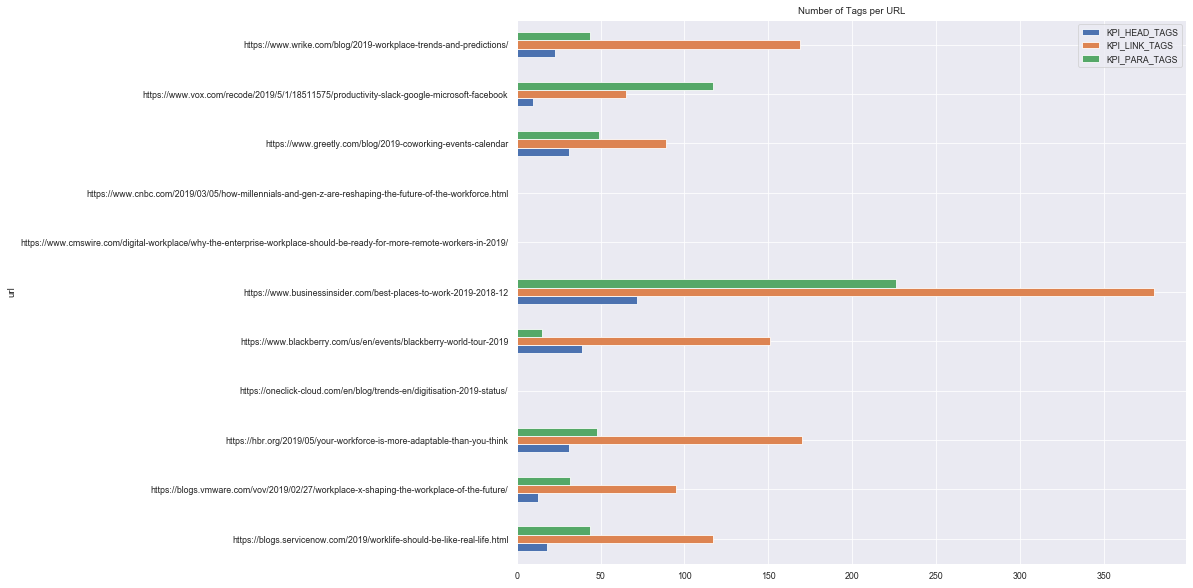

In [11]:
data_df.plot(x='url', y=['KPI_HEAD_TAGS', 'KPI_LINK_TAGS', 'KPI_PARA_TAGS'], kind='barh', figsize=(12,10), title='Number of Tags per URL')

## Clean Corpus
- Remove Punctuation
- Remove Leaning whitespaces
- Remove Newlines
- Remove Numbers
- Make lower case

In [12]:
data_df.CORPUS = data_df.CORPUS.str.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
data_df.CORPUS = data_df.CORPUS.str.strip().str.replace('\n', ' ')                       # Remove \n
data_df.CORPUS = data_df.CORPUS.str.replace('[0-9]', "", regex=True)                     # Remove numbers
data_df.CORPUS = data_df.CORPUS.str.lower()                                              # Lower case
data_df = data_df.dropna()                                                               # Drop missing values
print(data_df.shape)
data_df.head()

(8, 8)


url          datetime  count  \
0  https://blogs.servicenow.com/2019/worklife-sho...  2019-07-01_14-26      6   
1  https://blogs.vmware.com/vov/2019/02/27/workpl...  2019-07-01_14-26      6   
2  https://hbr.org/2019/05/your-workforce-is-more...  2019-07-01_14-26      6   
4  https://www.blackberry.com/us/en/events/blackb...  2019-07-01_14-26      3   
5  https://www.businessinsider.com/best-places-to...  2019-07-01_14-26      6   

                                              CORPUS  KPI_LINK_TAGS  \
0  solutions platform customers explore solutions...          117.0   
1  vmwarecom communities home vmware products clo...           95.0   
2  register for more   subscribe  save      subsc...          170.0   
4  blackberry enterprise mobility suite applicati...          151.0   
5  business insider logo the words business insid...          380.0   

   KPI_HEAD_TAGS  KPI_PARA_TAGS LANGUAGE  
0           18.0           44.0       en  
1           13.0           32.0       en  
2           31.0           48.0       en  
4           39.0           15.0       en  
5           72.0          226.0       en

# Vectorization 

Using **Spacy** medium model, we are creating average/min/max aggregation to tokens vectorizations for each row `CORPUS`. 
>[Reference](https://arxiv.org/pdf/1607.00570)

#### OBS.: This is considerably slow.

In [13]:
def get_avg_min_max_vec(nlp_doc):
    """Return the concatenated aggregation of the tokens vectors"""
    # Vectors for each token
    list_vectors = [s.vector for s in nlp_doc if s.has_vector]
    
    # If no token has a representation
    if len(list_vectors) <= 1:
        vectors = np.zeros((1, 300))
    else:
        vectors = np.stack(list_vectors)
    # Aggregations
    min_vec = vectors.min(axis=0)
    max_vec = vectors.max(axis=0)
    avg_vec = vectors.mean(axis=0)
    concat_vec = np.concatenate([min_vec, avg_vec, max_vec])
    
    # Versor
    norm = np.linalg.norm(concat_vec)
    if norm > 0:
        concat_vec = concat_vec / norm
    # result
    return concat_vec

In [14]:
# Apply spacy to all rows
nlp_corpus = [nlp(r) for r in tqdm_notebook(data_df.CORPUS)]

# Get vectors
vectors = np.stack([get_avg_min_max_vec(d) for d in tqdm_notebook(nlp_corpus)])

# Elbow Method

This [rule](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) is used to detect the ideal number of cluster.

In [15]:
def perform_elbow_method(vectorized_data, c0=1, c1=8, show_plot=True):
    cluster_models = []

    # For each ideal cluster
    for c in tqdm_nb(range(c0, c1 + 1)):
        # Calculate model
        cluster_models.append(KMeans(n_clusters=c, max_iter=1000, n_jobs=-2, n_init=40).fit(vectorized_data))

    if show_plot:
        # Variables
        x = range(c0, c1 + 1)
        y = [m.inertia_ for m in cluster_models]

        # Plot Elbow
        plt.figure(figsize=(16, 8))
        plt.plot(x, y)
        plt.title("Elbow Curve")
        plt.xticks(x)
        plt.xlim((c0, c1))
        plt.xlabel("Number of Clusters")
        plt.xlabel("Distortions")
    return cluster_models

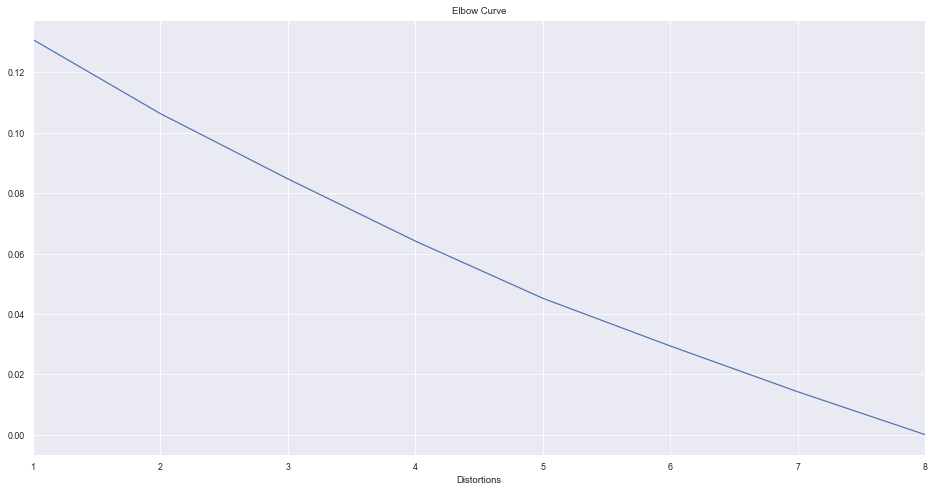

In [16]:
# Select best model from plot
cluster_models = perform_elbow_method(vectors)

**No clear Elbow (Low number of URLs). Selecting 3.**

In [17]:
# Clusters
best_model_spacy = cluster_models[2]
corpus_clusters_spacy = best_model_spacy.predict(vectors)

## Show Documents using TSNE

In [18]:
# Calculate TSNE
tsne = TSNE(n_components=2, init='pca')
projected_vector = tsne.fit_transform(vectors)

In [19]:
# Plot TSNE
def dynamic_plot_TSNE(projected_vector, corpus_clusters, n_char=400, data_df=data_df):
    palette = Palette[len(np.unique(corpus_clusters))]
    x = projected_vector[:, 0]
    y = projected_vector[:, 1]
    colors = [palette[c] for c in corpus_clusters]
    plot_df = pd.DataFrame({"X":x, "Y":y,"cluster":corpus_clusters,
                            "C":colors,"text":data_df.CORPUS.str[:n_char]})
    # Bokeh settings
    output_notebook()
    TOOLS="hover,crosshair,pan,wheel_zoom,box_zoom,reset,save,"
    TOOLTIPS = [
        ("index", "$index"),
        ("Text", "@text"),
        ("Cluster", "@cluster")
    ]
    p = figure(tools=TOOLS, 
               tooltips=TOOLTIPS,
               plot_width=1000)
    p.scatter("X", "Y", color="C", source=plot_df)
    show(p)

In [20]:
dynamic_plot_TSNE(projected_vector, corpus_clusters_spacy)

Loading BokehJS ...

# Create TF-ID Model

Other method to group content.

In [21]:
# Create TfidVectorizer
vectorizer = TfidfVectorizer(min_df=0, max_df=0.5, stop_words="english",
                             ngram_range=(1,1), max_features=200)

# Get DFM - Data Frequency Matrix
X = vectorizer.fit_transform(data_df.CORPUS)

# Get vocabulary
vocab = vectorizer.get_feature_names()

In [22]:
# Take a look at vocab
vocab[1:10]

['according',
 'account',
 'actually',
 'agent',
 'air',
 'amazing',
 'app',
 'application',
 'apps']

## Show DFM Matrix as a DataFrame

In [23]:
terms_df = pd.DataFrame(X.toarray(), columns=vocab)
terms_df.head()

ability  according   account  actually     agent       air  amazing  \
0  0.033963   0.000000  0.000000  0.033963  0.112222  0.000000  0.00000   
1  0.000000   0.000000  0.019135  0.000000  0.000000  0.000000  0.00000   
2  0.031279   0.000000  0.071349  0.015639  0.000000  0.000000  0.00000   
3  0.000000   0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
4  0.003969   0.001984  0.009053  0.000000  0.005246  0.021907  0.01836   

        app  application      apps  ...     users     using        ve  \
0  0.213045     0.067925  0.118869  ...  0.000000  0.000000  0.016981   
1  0.000000     0.000000  0.000000  ...  0.000000  0.016777  0.000000   
2  0.000000     0.015639  0.000000  ...  0.000000  0.015639  0.046918   
3  0.000000     0.000000  0.116799  ...  0.000000  0.000000  0.000000   
4  0.000000     0.001984  0.000000  ...  0.002623  0.001984  0.000000   

      video      view    vmware  webinars  workflows  workspace  wrike  
0  0.000000  0.033963  0.000000  0.038736   0.134667   0.084906    0.0  
1  0.000000  0.000000  0.978986  0.000000   0.000000   0.134218    0.0  
2  0.062558  0.015639  0.000000  0.053512   0.000000   0.000000    0.0  
3  0.000000  0.000000  0.000000  0.000000   0.000000   0.000000    0.0  
4  0.007938  0.005953  0.000000  0.000000   0.000000   0.000000    0.0  

[5 rows x 200 columns]

In [24]:
terms_df.shape

(8, 200)

# Scale the Bag of Words Representation

In [25]:
# MinMax Scaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(terms_df), columns=terms_df.columns)
df_scaled.head()

ability  according   account  actually     agent  air  amazing  app  \
0  1.000000   0.000000  0.000000  0.684272  1.000000  0.0      0.0  1.0   
1  0.000000   0.000000  0.268188  0.000000  0.000000  0.0      0.0  0.0   
2  0.920979   0.000000  1.000000  0.315100  0.000000  0.0      0.0  0.0   
3  0.000000   0.000000  0.000000  0.000000  0.000000  0.0      0.0  0.0   
4  0.116858   0.011423  0.126884  0.000000  0.046743  1.0      1.0  0.0   

   application     apps  ...     users     using        ve     video  \
0     1.000000  1.00000  ...  0.000000  0.000000  0.342136  0.000000   
1     0.000000  0.00000  ...  0.000000  0.174553  0.000000  0.000000   
2     0.230245  0.00000  ...  0.000000  0.162715  0.945299  1.000000   
3     0.000000  0.98259  ...  0.000000  0.000000  0.000000  0.000000   
4     0.029214  0.00000  ...  0.030969  0.020646  0.000000  0.126884   

       view  vmware  webinars  workflows  workspace  wrike  
0  1.000000     0.0  0.456181        1.0   0.632602    0.0  
1  0.000000     1.0  0.000000        0.0   1.000000    0.0  
2  0.460489     0.0  0.630200        0.0   0.000000    0.0  
3  0.000000     0.0  0.000000        0.0   0.000000    0.0  
4  0.175287     0.0  0.000000        0.0   0.000000    0.0  

[5 rows x 200 columns]

# Elbow Method

This [rule](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) is used to detect the ideal number of cluster.

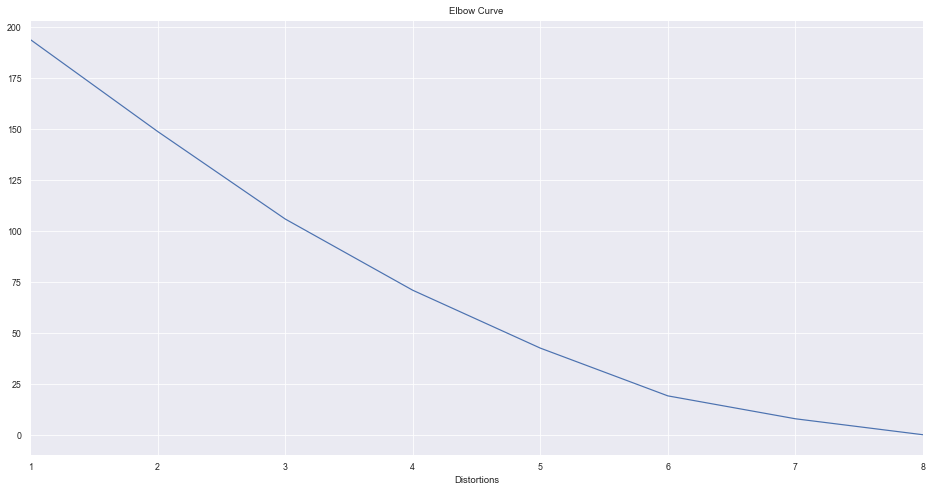

In [26]:
# Select best model from plot
cluster_models = perform_elbow_method(df_scaled)

**Checking the graph possible number of clusters could be 6 (Not reliable for low amount of data). Selecting 3.**

In [27]:
# Clusters
best_model_tfid = cluster_models[2]
corpus_clusters_tfid = best_model_tfid.predict(df_scaled)

## Show Top Words per Cluster

In [28]:
print("Top terms per cluster:")
ordered_centroids = best_model_tfid.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
#terms.append('cost')
for i in range(best_model_tfid.n_clusters):
    print('\n')
    print(" Cluster %d:" % i ),
    for ind in ordered_centroids[i, :15]:
           print(' %s ' % terms[ind], end = ''),
    print

Top terms per cluster:


 Cluster 0:
 consultant  library  quickly  subscribe  managers  strategy  store  managing  meet  developing  million  needs  benefits  opportunity  big 

 Cluster 1:
 workspace  apps  developer  provider  health  linkedin  sales  home  create  manager  love  financial  portal  assistant  site 

 Cluster 2:
 think  conversations  gets  good  ve  mckinsey  google  according  messaging  data  communication  tasks  average  getting  actually 

In [29]:
# Calculate TSNE
tsne = TSNE(n_components=2, init='pca')
projected_vector = tsne.fit_transform(df_scaled)

In [30]:
dynamic_plot_TSNE(projected_vector, corpus_clusters_spacy)

Loading BokehJS ...

# Add Cluster Label to CSV File

In [31]:
# Add cluster label
data_df["cluster_spacy"] = corpus_clusters_spacy
data_df["cluster_tfid"] = corpus_clusters_tfid

In [32]:
data_df

url          datetime  \
0   https://blogs.servicenow.com/2019/worklife-sho...  2019-07-01_14-26   
1   https://blogs.vmware.com/vov/2019/02/27/workpl...  2019-07-01_14-26   
2   https://hbr.org/2019/05/your-workforce-is-more...  2019-07-01_14-26   
4   https://www.blackberry.com/us/en/events/blackb...  2019-07-01_14-26   
5   https://www.businessinsider.com/best-places-to...  2019-07-01_14-26   
8   https://www.greetly.com/blog/2019-coworking-ev...  2019-06-29_01-19   
9   https://www.vox.com/recode/2019/5/1/18511575/p...  2019-07-01_14-26   
10  https://www.wrike.com/blog/2019-workplace-tren...  2019-07-01_14-26   

    count                                             CORPUS  KPI_LINK_TAGS  \
0       6  solutions platform customers explore solutions...          117.0   
1       6  vmwarecom communities home vmware products clo...           95.0   
2       6  register for more   subscribe  save      subsc...          170.0   
4       3  blackberry enterprise mobility suite applicati...          151.0   
5       6  business insider logo the words business insid...          380.0   
8       3  pricing about industries coworking technology ...           89.0   
9       6  skip to main content   the productivity pit ho...           65.0   
10      6  login  marketing teams   creative teams   proj...          169.0   

    KPI_HEAD_TAGS  KPI_PARA_TAGS LANGUAGE  cluster_spacy  cluster_tfid  
0            18.0           44.0       en              1             1  
1            13.0           32.0       en              2             1  
2            31.0           48.0       en              1             0  
4            39.0           15.0       en              2             1  
5            72.0          226.0       en              1             1  
8            31.0           49.0       en              0             1  
9            10.0          117.0       en              1             2  
10           23.0           44.0       en              1             2

In [33]:
# Save first n_char from corpus
n_char = 250
data_df['CORPUS_simp'] = data_df.CORPUS.str[:n_char]

In [34]:
# Save new file
data_df.to_excel("dataset_with_clusters.xlsx")

## Save Checkpoint

In [35]:
# Save Calculation
checkpoint = {"Corpus_Data": data_df.CORPUS,
              "Vectorized_Text": vectors,
              "KMeans_spacy": best_model_spacy,
              "KMeans_tfid": best_model_tfid
             }
# Save objects
pickle.dump(checkpoint, open('checkpoint.sav', 'wb'))

## Load Checkpoint

In [36]:
# Load data from file
checkpoint = pickle.load(open('checkpoint.sav', 'rb'))

# Load varibales
corpus_mwa = checkpoint["Corpus_Data"]
vectors = checkpoint["Vectorized_Text"]
tfid_kmeans_model = checkpoint["KMeans_tfid"]
spacy_kmeans_model = checkpoint["KMeans_spacy"]
